
<h3 align="center"> Image Classification: Identifying Types of Big Cats </h3> 
In this notebook we will experiment with different Convolutional Neural Networks (CNNs) to see which architecture leads to the highest performance.












# Table of Contents

<To fill in once the notebook is completed>

## 1 Introduction
The dataset was obtained from Kaggle, the popular data science platform and it contains c. 2500 images of size 224x224x3 of 10 different types of big cats such as tigers and cheetahs. The objective of the models would be to correctly predict the type of big cat in each image. As such, this is a multiclass classification task specifically in machine vision. There are numerous applications of machine vision in real-life use cases; from self-driving cars to till-less supermarkets like Amazon Fresh. For this topic, a highly accurate image classification model can be a powerfool tool to enable conservationists and researchers to better understand wildcats and their behaviours. Therefore, conservation parks could be improved to make them more hospital for many mammals of the Felidae family.

### 1.1 Package imports

In [1]:
# Autosaving and making sure every output is printed
%autosave 120
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Autosaving every 120 seconds


In [2]:
%%capture
# this magic command suppresses the installation output
# Installing relevant Python packages and modules 
from IPython import display as dp
import warnings

# Import standard Python libraries
import numpy as np
import pandas as pd
import itertools
import random
import tensorflow as tf
import pickle as pkl

# Import visualization libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import matplotlib.cm as cm
import cv2

%matplotlib inline

# Pre-processing functions from sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Logistic regression and other classifiers for baseline model
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix, auc

In [3]:
# Setting the parameters to print all rows and columns if we wish in pandas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
# Setting the default option to be 2 decimal places for floats
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### 1.2 Bespoke functions

In [4]:
# Defining any bespoke functions

def seed_everything(seed=7):
  """ This functions sets the same seed for different applications to ensure reproducibility.
  """
    # Seed value for TensorFlow
  tf.random.set_seed(seed)
    
    # Seed value for NumPy
  np.random.seed(seed)
    
    # Seed value for Python's random library
  random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
  session_conf = tf.compat.v1.ConfigProto(
      intra_op_parallelism_threads=1,
      inter_op_parallelism_threads=1
  )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
  tf.compat.v1.set_random_seed(seed)

  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)


def convert_path_to_df(dataset):
  """ This function creates a dataframe where the first column contains the image path and the second column contains the animal label.
  """
  image_dir = Path(dataset)

  # Get filepaths and labels
  filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

  labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

  filepaths = pd.Series(filepaths, name='Filepath').astype(str)
  labels = pd.Series(labels, name='Label')

  # Concatenate filepaths and labels
  image_df = pd.concat([filepaths, labels], axis=1)
  return image_df

def compute_ela_cv(path, quality):
  """ The function takes an image path and a quality parameter, compresses the image using JPEG compression at the given quality 
  and computes the absolute difference between the compressed and original images. The difference is multiplied by a scale factor and returned as an ELA image.
  """
  temp_filename = 'temp_file_name.jpg'
  SCALE = 15
  orig_img = cv2.imread(path)
  orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
  cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

  # read compressed image
  compressed_img = cv2.imread(temp_filename)

  # get absolute difference between img1 and img2 and multiply by scale
  diff = SCALE * cv2.absdiff(orig_img, compressed_img)
  return diff


def convert_to_ela_image(path, quality):
  """ The function takes an image path and a quality parameter, compresses the image using JPEG compression at the given quality,
  computes the absolute difference between the compressed and original images, and returns an ELA image. 
  The ELA image is computed using the difference in pixel values between the original and compressed images, and is normalized to enhance the differences.
  """
  temp_filename = 'temp_file_name.jpg'
  ela_filename = 'temp_ela.png'
  image = Image.open(path).convert('RGB')
  image.save(temp_filename, 'JPEG', quality = quality)
  temp_image = Image.open(temp_filename)

  ela_image = ImageChops.difference(image, temp_image)

  extrema = ela_image.getextrema()
  max_diff = max([ex[1] for ex in extrema])
  if max_diff == 0:
      max_diff = 1

  scale = 255.0 / max_diff
  ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
  return ela_image


def random_sample(path, extension=None):
  """ function takes a directory path and an optional file extension, and returns a random file path from that directory with the specified extension (if provided).
  """
  if extension:
      items = Path(path).glob(f'*.{extension}')
  else:
      items = Path(path).glob(f'*')
        
  items = list(items)
        
  p = random.choice(items)
  return p.as_posix()

In [5]:
# Calling the seed_everything function to fix the seed
seed_everything()

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-03-24 22:01:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-24 22:01:38 (30.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 2 Data

In [7]:
# Setting the batch size for the training
batch_size = 32
# The target size matches the pixel dimensions of the image
target_size = (224, 224)

In [8]:
# Mount the Google drive to collab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
# Navigate to the folder where the data is stored and print information about the subfolders within it
dataset = "gdrive/MyDrive/Predictive_analytics_individual_assignment/Data/Images"
walk_through_dir(dataset)

There are 3 directories and 3 images in 'gdrive/MyDrive/Predictive_analytics_individual_assignment/Data/Images'.
There are 10 directories and 0 images in 'gdrive/MyDrive/Predictive_analytics_individual_assignment/Data/Images/test'.
There are 0 directories and 5 images in 'gdrive/MyDrive/Predictive_analytics_individual_assignment/Data/Images/test/AFRICAN LEOPARD'.
There are 0 directories and 5 images in 'gdrive/MyDrive/Predictive_analytics_individual_assignment/Data/Images/test/CARACAL'.
There are 0 directories and 5 images in 'gdrive/MyDrive/Predictive_analytics_individual_assignment/Data/Images/test/CHEETAH'.
There are 0 directories and 5 images in 'gdrive/MyDrive/Predictive_analytics_individual_assignment/Data/Images/test/CLOUDED LEOPARD'.
There are 0 directories and 5 images in 'gdrive/MyDrive/Predictive_analytics_individual_assignment/Data/Images/test/JAGUAR'.
There are 0 directories and 5 images in 'gdrive/MyDrive/Predictive_analytics_individual_assignment/Data/Images/test/LIONS'.

In [10]:
image_df = convert_path_to_df(dataset)

In [11]:
# Print the first 5 lines of the code
image_df.head(5)

,Filepath,Label
0,gdrive/MyDrive/Predictive_analytics_individual...,AFRICAN LEOPARD
1,gdrive/MyDrive/Predictive_analytics_individual...,AFRICAN LEOPARD
2,gdrive/MyDrive/Predictive_analytics_individual...,AFRICAN LEOPARD
3,gdrive/MyDrive/Predictive_analytics_individual...,AFRICAN LEOPARD
4,gdrive/MyDrive/Predictive_analytics_individual...,AFRICAN LEOPARD


# 3 EDA

Text(0.5, 1.0, 'AFRICAN LEOPARD')

Text(0.5, 1.0, 'JAGUAR')

Text(0.5, 1.0, 'CHEETAH')

Text(0.5, 1.0, 'OCELOT')

Text(0.5, 1.0, 'AFRICAN LEOPARD')

Text(0.5, 1.0, 'CLOUDED LEOPARD')

Text(0.5, 1.0, 'OCELOT')

Text(0.5, 1.0, 'LIONS')

Text(0.5, 1.0, 'CARACAL')

Text(0.5, 1.0, 'CARACAL')

Text(0.5, 1.0, 'CLOUDED LEOPARD')

Text(0.5, 1.0, 'SNOW LEOPARD')

Text(0.5, 1.0, 'JAGUAR')

Text(0.5, 1.0, 'OCELOT')

Text(0.5, 1.0, 'PUMA')

Text(0.5, 1.0, 'CARACAL')

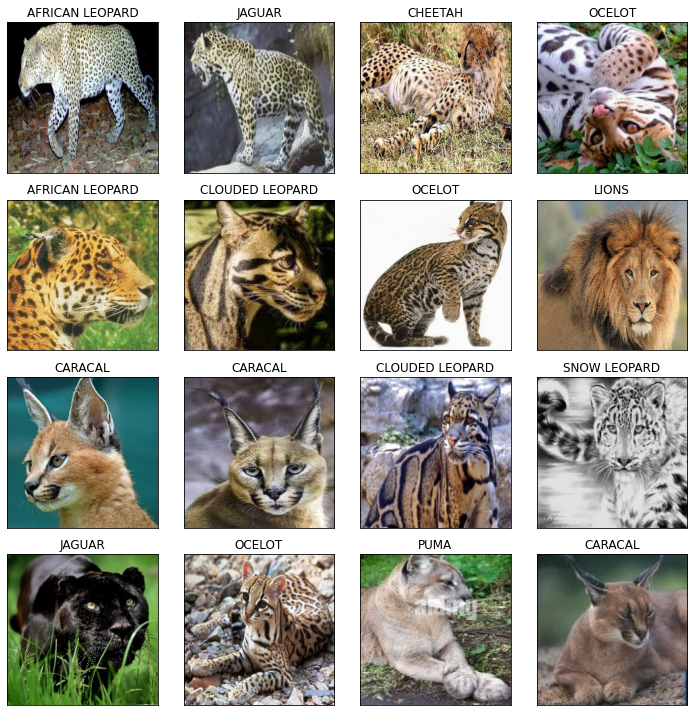

In [12]:
# I'm displaying a random sample of 16 pictures from the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

### 3.1 Computing Error Level Analysis (ELA)
The code below performs error level analysis (ELA) of the wildcat images.

Using the **random_sample**, **compute_ela_cv** and **convert_to_ela_image** functions defined earlier, the code generates a set of ELA images for a randomly selected image from the test dataset of wildcat images. The ELA images are generated with decreasing quality levels, resulting in increasing levels of compression and thus increasing levels of error. The resulting images are plotted using matplotlib.

Overall, this code provides a way to visually analyze the effect of different levels of JPEG compression on wildcat images, and may be used to identify optimal quality levels for image compression in the context of a wildcat image classification task. JPEG compression could be used as regilarisation technique to prevent the model from overfitting

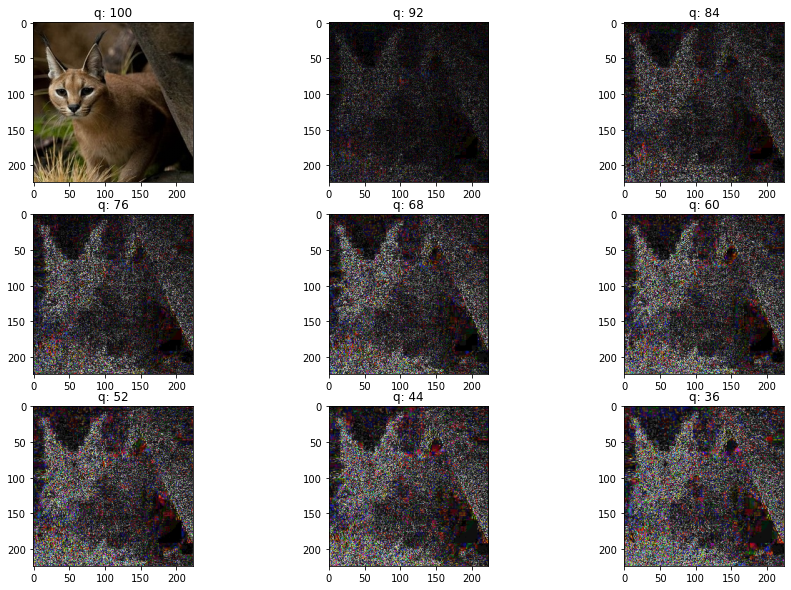

In [13]:
picture= random_sample('gdrive/MyDrive/Predictive_analytics_individual_assignment/Data/Images/test/CARACAL')
orig = cv2.imread(picture)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=picture, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

### 3.2 Data pre-processing 

The images are already split into training, validation and test sets. The training data will be used to train the different candidate models while the validation set will be used to select the optimal hyperparameter values from fine tuning. Finally, the model's ability to generalise on unseen data wil be measured using the test set.

In [14]:
main_path = "gdrive/MyDrive/Predictive_analytics_individual_assignment/Data/Images/"

train_path = main_path + "train"
validation_path = main_path + "valid"
test_path = main_path + "test"

train_df = convert_path_to_df(train_path)
val_df = convert_path_to_df(validation_path)
test_df = convert_path_to_df(test_path)

In [15]:
# Shuffle the dataframes
train_df =train_df.sample(frac=1, replace= False, random_state= 7)
val_df =val_df.sample(frac=1, replace= False, random_state= 7)
test_df =test_df.sample(frac=1, replace= False, random_state= 7)

In [16]:
# We need to create numpy arrays of the pixel values for each sample
# WARNING: This steps takes around 5-10 minutes because I'm iterrating through each row of the training, validation and test sets

# Training sample
pixel_train = []

for index, row in train_df.iterrows():
  # Convert image file path to pixels
  image = plt.imread(row['Filepath'])
  # Flatten the array and append it to the list
  pixel_train.append(np.ravel(image, order='C').reshape(-1,150528))

# Convert the list to a numpy array
X_train = np.array(pixel_train).reshape(2339,150528)
# Extract the image labels
y_train = (train_df['Label'].values).reshape(-1,1)

# Repeat the process for the validation and test sets
# Validation
pixel_val = []

for index, row in val_df.iterrows():
  image = plt.imread(row['Filepath'])
  pixel_val.append(np.ravel(image, order='C').reshape(-1,150528))

X_val = np.array(pixel_val).reshape(50,150528)
y_val = (val_df['Label'].values).reshape(-1,1)

pixel_test = []

for index, row in test_df.iterrows():
  image = plt.imread(row['Filepath'])
  pixel_test.append(np.ravel(image, order='C').reshape(-1,150528))

X_test = np.array(pixel_test).reshape(50,150528)
y_test = (test_df['Label'].values).reshape(-1,1)

In [17]:
# Check that the test set has the same number of rows 
print(X_test.shape)
print(y_test.shape)

(50, 150528)
(50, 1)


In [18]:
# Let's standardise the pixel sizes in the sample sets
# This will help with convergence of solutions when fitting the model

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# To prevent leakage of information we're only transforming in the validation and test sets
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Encode the string labels as categorical values
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.fit_transform(y_val)
y_test = encoder.fit_transform(y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Below is the label mapping to be used for the classification models.

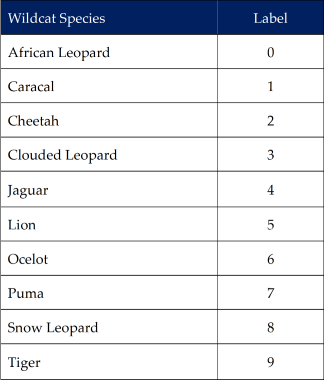

#### 3.2.1 Data pre-processing and augmentation for the CNN models

In [ ]:
# I'm using the ImageDataGenerator class from Keras pre-processing to generate batches of tensor image data
# Instanstiating the image generators for each set
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

In [ ]:
# Split the data into three categories
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=7,
    subset='training'
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=7,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 2339 validated image filenames belonging to 10 classes.
Found 50 validated image filenames belonging to 10 classes.
Found 50 validated image filenames belonging to 10 classes.


In [ ]:
# For the first round of models, I'm onlt applying resizing and rescaling to the images to ensure that pixel values are in a more manageable range
# This will help with the optimisation
normalise = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# Data augmentation is performed in order to pre-process the underlying training data
# This will help to moderate overfitting
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224), # applying resizing of images
  layers.experimental.preprocessing.Rescaling(1./255), # rescaling
  layers.experimental.preprocessing.RandomFlip("horizontal"), # flipping images horizontally at random
  layers.experimental.preprocessing.RandomRotation(0.1), # random rotation
  layers.experimental.preprocessing.RandomZoom(0.1), # random zooming in
  layers.experimental.preprocessing.RandomContrast(0.1), # random contrasting
])

# 4 Modelling

### 4.1 Baseline model
For the baseline model, I opted for a simple Logistic regression to establish the accuracy of such model. Interestingly, before deep learning models became popular, machine vision was performed using traditional supervised learning algorithms such the Logistic regression. However, since the labels are not binary, I'm experimenting with two mutliclass classifiers: One-Versus-One (OVO) and One-Versus-Rest (OVR).

In [37]:
# The models were already trained once and they take around 1 hour each to do so due to the high number of pixel columns
# The weights were saved and will be loaded here
model_path = "/content/gdrive/MyDrive/Predictive_analytics_individual_assignment/"
ovr_clf = pkl.load(open(model_path + 'one_vs_rest_logistic_classifier.pkl', 'rb'))
ovo_clf = pkl.load(open(model_path + 'one_vs_one_logistic_classifier.pkl', 'rb'))

#### 4.1.1 One-Vs-One Classifier
Here 45 different classifiers will be estimated for each possible pair of labels (e.g. Jaguar vs Tiger).

In [24]:
# Create an instance of the OneVsOneClassifier class with LogisticRegression as the base estimator
#clf = LogisticRegression(max_iter=1000, random_state=7)
#ovo_clf = OneVsOneClassifier(clf)

# Fit the model on the training data
# WARNING: The model takes 30+ minutes to fit due to the high number of columns
#ovo_clf.fit(X_train, y_train)

# Evaluate the model performance on train and test sets
y_pred_train = ovo_clf.predict(X_train)
y_pred_test = ovo_clf.predict(X_test)

In [25]:
# Performance metrics on train set
print('Accuracy:', accuracy_score(y_train, y_pred_train))
print('Precision:', precision_score(y_train, y_pred_train, average='weighted'))
print('Recall:', recall_score(y_train, y_pred_train, average='weighted'))
print('F1 score:', f1_score(y_train, y_pred_train, average='weighted'))
print('Classification report: \n', classification_report(y_train,y_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train,y_pred_train))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       236
           1       1.00      1.00      1.00       236
           2       1.00      1.00      1.00       235
           3       1.00      1.00      1.00       229
           4       1.00      1.00      1.00       238
           5       1.00      1.00      1.00       228
           6       1.00      1.00      1.00       233
           7       1.00      1.00      1.00       236
           8       1.00      1.00      1.00       231
           9       1.00      1.00      1.00       237

    accuracy                           1.00      2339
   macro avg       1.00      1.00      1.00      2339
weighted avg       1.00      1.00      1.00      2339

Confusion matrix:
 [[236   0   0   0   0   0   0   0   0   0]
 [  0 236   0   0   0   0   0   0   0   0]
 [  0   0 235   0   0   0   0   0   0   0]
 [  0   0   0

In [26]:
# Test set metrics
print('Accuracy:', accuracy_score(y_test, y_pred_test))
print('Precision:', precision_score(y_test, y_pred_test, average='weighted'))
print('Recall:', recall_score(y_test, y_pred_test, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred_test, average='weighted'))
print('Classification report: \n', classification_report(y_test,y_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test,y_pred_test))
conf_mx_ovo = confusion_matrix(y_test,y_pred_test)

Accuracy: 0.4
Precision: 0.3678571428571428
Recall: 0.4
F1 score: 0.3677350427350427
Classification report: 
               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.33      0.20      0.25         5
           2       0.38      0.60      0.46         5
           3       0.43      0.60      0.50         5
           4       0.25      0.20      0.22         5
           5       0.38      0.60      0.46         5
           6       0.25      0.20      0.22         5
           7       0.50      0.80      0.62         5
           8       0.67      0.40      0.50         5
           9       0.00      0.00      0.00         5

    accuracy                           0.40        50
   macro avg       0.37      0.40      0.37        50
weighted avg       0.37      0.40      0.37        50

Confusion matrix:
 [[2 1 1 0 0 1 0 0 0 0]
 [0 1 1 1 0 1 0 1 0 0]
 [1 0 3 0 0 1 0 0 0 0]
 [0 1 0 3 0 0 1 0 0 0]
 [0 0 2 0 1 1 0 1 0 

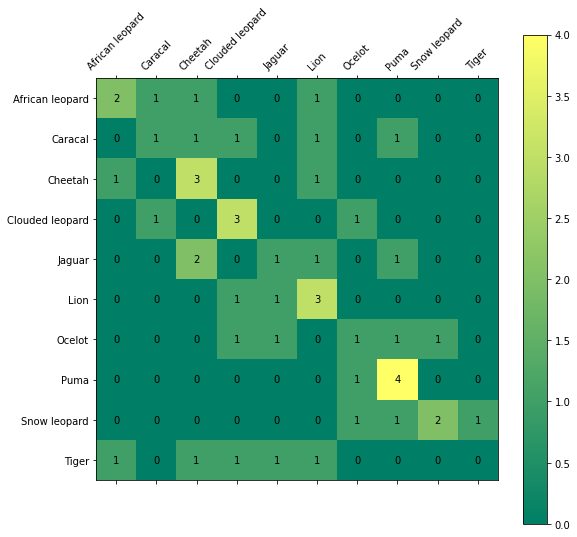

In [28]:
%matplotlib inline
warnings.filterwarnings("ignore")

wildcats= ['','African leopard', 'Caracal', 'Cheetah', 'Clouded leopard', 'Jaguar', 'Lion', 'Ocelot', 'Puma', 'Snow leopard', 'Tiger']

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
heatmap = ax.matshow(conf_mx_ovo, cmap='summer')

for i in range(len(wildcats[1:])):
    for j in range(len(wildcats[1:])):
        text = ax.text(j, i, conf_mx_ovo[i, j],
                       ha="center", va="center", color="k")
        
ax.set_xticklabels(wildcats, rotation= 45)
ax.set_yticklabels(wildcats)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
fig.colorbar(heatmap)

plt.show();


Some initial observations from the OvO classifier is that it has overfitted to the data due to the fact that it has 100% accuracy on the train set yet only achieves 40% accuracy score on the test set. It is better than a random classifier (the accuracy would be 10%) but it is still far from a satisfactory performance. From the heatmap, we can see that the highest accuracy was for the **Puma** class followed by **Lion, Clouded Leopard** and **Cheetah**.

#### 4.1.2 One-Vs-Rest Classifier
On the other hand, with a OvR classifier, there will be just 10 unique classifiers (e.g. Jaguar vs Not Jaguar and so on). Let's see what accuracy level this type of classifier can reach.

In [29]:
#clf = LogisticRegression(max_iter=1000, random_state=7)
#ovr_clf = OneVsRestClassifier(clf)

# Fit the model on the training data
# WARNING: The model takes c.2 hours minutes to fit due to the high number of columns
#ovr_clf.fit(X_train, y_train)

# Evaluate the model performance on train and test sets
y_pred_train_ovr = ovr_clf.predict(X_train)
y_pred_test_ovr = ovr_clf.predict(X_test)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, random_state=7))

In [30]:
# Train set performance metrics
print('Accuracy:', accuracy_score(y_train, y_pred_train_ovr))
print('Precision:', precision_score(y_train, y_pred_train_ovr, average='weighted'))
print('Recall:', recall_score(y_train, y_pred_train_ovr, average='weighted'))
print('F1 score:', f1_score(y_train, y_pred_train_ovr, average='weighted'))
print('Classification report: \n', classification_report(y_train,y_pred_train_ovr))
print('Confusion matrix:\n', confusion_matrix(y_train,y_pred_train_ovr))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       236
           1       1.00      1.00      1.00       236
           2       1.00      1.00      1.00       235
           3       1.00      1.00      1.00       229
           4       1.00      1.00      1.00       238
           5       1.00      1.00      1.00       228
           6       1.00      1.00      1.00       233
           7       1.00      1.00      1.00       236
           8       1.00      1.00      1.00       231
           9       1.00      1.00      1.00       237

    accuracy                           1.00      2339
   macro avg       1.00      1.00      1.00      2339
weighted avg       1.00      1.00      1.00      2339

Confusion matrix:
 [[236   0   0   0   0   0   0   0   0   0]
 [  0 236   0   0   0   0   0   0   0   0]
 [  0   0 235   0   0   0   0   0   0   0]
 [  0   0   0

In [31]:
# Test set performance metrics
print('Accuracy:', accuracy_score(y_test, y_pred_test_ovr))
print('Precision:', precision_score(y_test, y_pred_test_ovr, average='weighted'))
print('Recall:', recall_score(y_test, y_pred_test_ovr, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred_test_ovr, average='weighted'))
print('Classification report: \n', classification_report(y_test,y_pred_test_ovr))
print('Confusion matrix:\n', confusion_matrix(y_test,y_pred_test_ovr))

conf_mx_ovr = confusion_matrix(y_test,y_pred_test_ovr)

Accuracy: 0.38
Precision: 0.4508333333333333
Recall: 0.38
F1 score: 0.3771017871017871
Classification report: 
               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.75      0.60      0.67         5
           2       0.67      0.40      0.50         5
           3       0.33      0.40      0.36         5
           4       1.00      0.20      0.33         5
           5       0.30      0.60      0.40         5
           6       0.33      0.40      0.36         5
           7       0.12      0.20      0.15         5
           8       0.50      0.60      0.55         5
           9       0.00      0.00      0.00         5

    accuracy                           0.38        50
   macro avg       0.45      0.38      0.38        50
weighted avg       0.45      0.38      0.38        50

Confusion matrix:
 [[2 1 0 0 0 0 0 1 1 0]
 [0 3 0 1 0 1 0 0 0 0]
 [1 0 2 0 0 2 0 0 0 0]
 [0 0 0 2 0 1 1 0 0 1]
 [1 0 0 1 1 1 0 1 

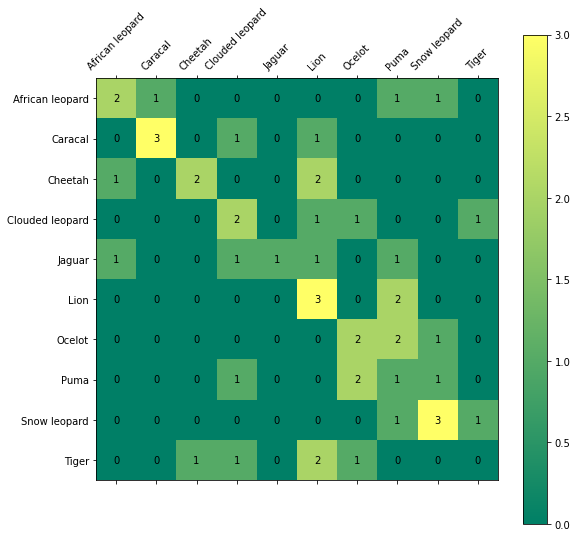

In [35]:
%matplotlib inline
# Visualisation of confusion matrix

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
heatmap = ax.matshow(conf_mx_ovr, cmap='summer')

for i in range(len(wildcats[1:])):
    for j in range(len(wildcats[1:])):
        text = ax.text(j, i, conf_mx_ovr[i, j],
                       ha="center", va="center", color="k")
        
ax.set_xticklabels(wildcats, rotation= 45)
ax.set_yticklabels(wildcats)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
fig.colorbar(heatmap)

plt.show();

The models are clearly overfitting and they could be regularised with L1 or L2 parameters. However, due to the high dimensionility of the images (over 150k pixel columns) fine-tuning different classifier models would take excessively long. Therefore, we will leave regularisation and hyperparameter tuning for the deep learning models.

In [36]:
# Save the two classifier models for future use (saves time to re-train them every time)
#ovo_model = 'one_vs_one_logistic_classifier.pkl'
#pkl.dump(ovo_clf, open(model_path + ovo_model, 'wb'))
#ovr_model = 'one_vs_rest_logistic_classifier.pkl'
#pkl.dump(ovr_clf, open(model_path + ovr_model, 'wb'))

### 4.2 Convolutional Neural Network models

#### 4.2.1 Designing & training my own CNN
Convolutional layers are more appropriate for an image classification task than fully-connected perceptron layers because of the formers' ability to identify patterns in small areas of the image. Therefore, I'll be opting with a CNN for my first deep learning candidate model.

#### Setting up the callbacks and instantiating the model

In [39]:
# I'm creating a callback checkpoint to ensure that weights are trained as the model is training
checkpoint_path = "/content/gdrive/MyDrive/Predictive_analytics_individual_assignment/classification_deep_model_checkpoint_candidate_one"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [40]:
# I'm also introducing early stopping to stop training if model's validation loss does not improve for 10 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 10,
                               restore_best_weights = True) # if val loss decreases for 10 epochs in a row, stop training

In [41]:
# Design the model architecture

inputs = keras.Input(shape=(224, 224, 3))

# Normalising the input pixels
x = normalise(inputs) 
# Creating the first 2D convolutional layer with relu activations function and zero padding
x = Conv2D(64, 7, activation="relu", padding="same", input_shape=[28, 28, 1])(x)
# Max pooling layer with pool size 2
x = MaxPooling2D(2)(x)
# A second 2d convolutional layer
x= Conv2D(128, 3, activation="relu", padding="same")(x)
# Followed by a third
x = Conv2D(128, 3, activation="relu", padding="same")(x)
# Another max pooling layer with pool size 2
x = MaxPooling2D(2)(x)
# Flatten the inputs since the dense layer can only accept 1D arrays
x = Flatten()(x)
# Now we introduce a fully connected dense layer
x = Dense(128, activation="relu")(x)
# Finally I introduce one dropout layer to control for overfitting
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)


# The output layer is another dense layer with 10 heads (one for each class) and has a softmax activation function
output = keras.layers.Dense(10, activation="softmax")(x)

model = Model(inputs=inputs, outputs=output)

# We opt for categorical cross entropy as the loss function given that it is a multiclass classification problem 
# and we want to obtain as much information about the model's predictions across all classes as possible
model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#### Fitting the CNN

In [45]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100, 
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "wild_cats_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/wild_cats_classification/20230324-204527
Epoch 1/100
74/74 [==============================] - 132s 2s/step - loss: 2.2995 - accuracy: 0.1201 - val_loss: 2.2957 - val_accuracy: 0.1400
Epoch 2/100
74/74 [==============================] - 17s 226ms/step - loss: 2.2907 - accuracy: 0.1295 - val_loss: 2.2825 - val_accuracy: 0.2000
Epoch 3/100
74/74 [==============================] - 13s 172ms/step - loss: 2.2777 - accuracy: 0.1381 - val_loss: 2.2685 - val_accuracy: 0.1800
Epoch 4/100
74/74 [==============================] - 12s 164ms/step - loss: 2.2631 - accuracy: 0.1522 - val_loss: 2.2530 - val_accuracy: 0.1400
Epoch 5/100
74/74 [==============================] - 12s 159ms/step - loss: 2.2476 - accuracy: 0.1633 - val_loss: 2.2262 - val_accuracy: 0.1200
Epoch 6/100
74/74 [==============================] - 44s 604ms/step - loss: 2.2340 - accuracy: 0.1663 - val_loss: 2.2061 - val_accuracy: 0.1400
Epoch 7/100
74/74 [==============================]

In [48]:
# Save the model for future use
#model.save(model_path + "cnn_candidate_one_normalised.h5")

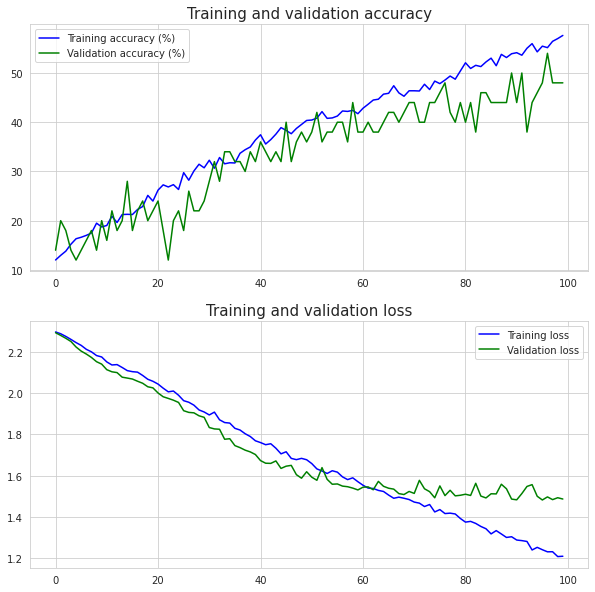

In [62]:
# Visualising the loss and accuracy rates
# Loss curves
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy curves
accuracy = [acc * 100 for acc in history.history['accuracy']]
val_accuracy = [acc * 100 for acc in history.history['val_accuracy'] ]

epochs = range(len(accuracy))

sns.set_style("whitegrid")
fig = plt.figure(figsize=(10,10))
axs = fig.subplots(2,1)

axs[0].plot(epochs, accuracy, 'b', label='Training accuracy (%)')
axs[0].plot(epochs, val_accuracy, 'g', label='Validation accuracy (%)')

axs[0].set_title('Training and validation accuracy', size=15)
axs[0].legend()

# Loss curves
axs[1].plot(epochs, loss, 'b', label='Training loss')
axs[1].plot(epochs, val_loss, 'g', label='Validation loss')
axs[1].set_title('Training and validation loss', size=15)
axs[1].legend()

plt.show();

As we can see, while model accuracy on the train set could increase with a greater number of epochs, the accuracy on the validation set reached a plateau at around the 60-epoch mark reaching an accuracy score of c. 46% on average. For this reason, there is no benefit to training the model for more epochs as we would be overfitting to the training set. Similar observations can be made for the loss curves.

In [63]:
# Load the model
model = keras.models.load_model(model_path + "cnn_candidate_one_normalised.h5")

#### Test set results

In [64]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 1.36101
Test Accuracy: 46.00%


In [69]:
# Let's measure the model's performance on the test set
pred = model.predict(test_images)
# Take the predicted class with the highest probability as the predicted class
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
actuals = list(test_df['Label'].values)

# Display the result
#print(f'The first 5 predictions: {pred[:5]}')

# Display the overall accuracy
print('The accuracy score of the first CNN on the test set is {:.2f}'.format((accuracy_score(actuals, pred))*100))

2/2 [==============================] - 1s 272ms/step
The accuracy score of the first CNN on the test set is 46.00


The CNN's accuracy score is higher than the OvO classifier by just 8% on the test set.

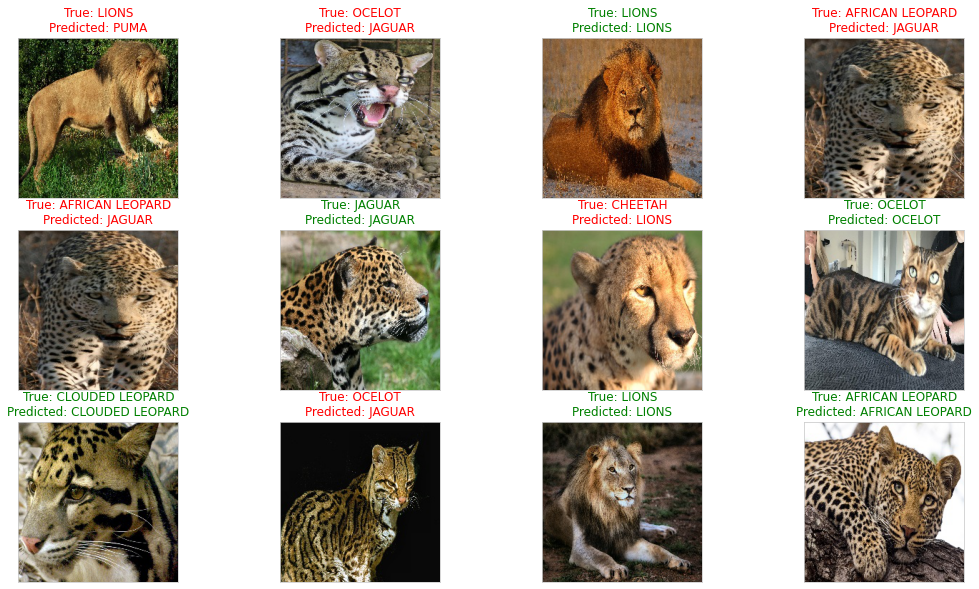

<Figure size 432x288 with 0 Axes>

In [70]:
# Display a sample of 12 randomly selected images from the test set
random_index = np.random.randint(0, len(test_df) - 1, 12)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout();

Classification report: 
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.17      0.20      0.18         5
        CARACAL       0.50      0.60      0.55         5
        CHEETAH       0.40      0.40      0.40         5
CLOUDED LEOPARD       1.00      0.60      0.75         5
         JAGUAR       0.25      0.40      0.31         5
          LIONS       0.57      0.80      0.67         5
         OCELOT       0.50      0.40      0.44         5
           PUMA       0.40      0.40      0.40         5
   SNOW LEOPARD       0.75      0.60      0.67         5
          TIGER       0.50      0.20      0.29         5

       accuracy                           0.46        50
      macro avg       0.50      0.46      0.46        50
   weighted avg       0.50      0.46      0.46        50



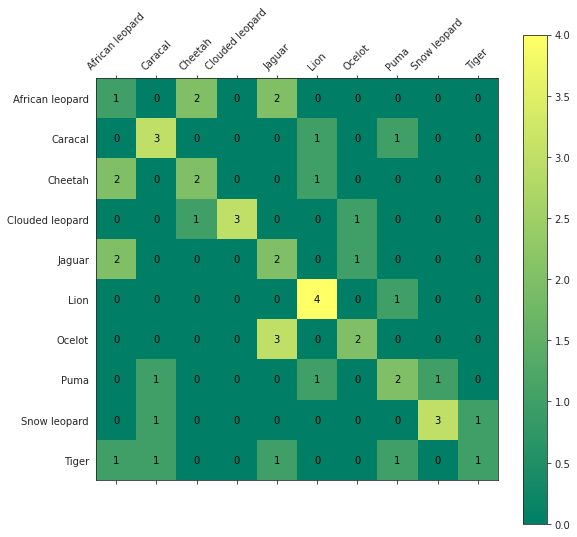

In [71]:
# Let's do some error analysis using classification report and confusion matrix
print('Classification report: \n', classification_report(actuals, pred))

wildcats= ['','African leopard', 'Caracal', 'Cheetah', 'Clouded leopard', 'Jaguar', 'Lion', 'Ocelot', 'Puma', 'Snow leopard', 'Tiger']

warnings.filterwarnings("ignore")

sns.set_style('white')
conf_mx_cnn = confusion_matrix(actuals, pred)
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
heatmap = ax.matshow(conf_mx_cnn, cmap= 'summer')

for i in range(len(wildcats[1:])):
    for j in range(len(wildcats[1:])):
        text = ax.text(j, i, conf_mx_cnn[i, j],
                       ha="center", va="center", color="k")

ax.set_xticklabels(wildcats, rotation= 45)
ax.set_yticklabels(wildcats)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
fig.colorbar(heatmap)

plt.show();

Although the early stopping and dropout layer have prevented the CNN from overfitting on the training data (evident by the 55% accuracy), the model's performance on the test set is rather underwhelming. What's interesting is that the failure modes in this model are different to the baseline classifiers. For example, this model classified almost all lions correctly (4 out of 5 correct) but did a relatively poor job for the Puma class which the OvO classifier did relatively well at. 

Perhaps the relatively simple architecture of this CNN is not robust enough to capture all the information from the image patterns. A pre-trained computer vision model should be able to outperform this CNN.

In [72]:
# Before using a pre-trained model, let's try and augment the training data by using the pipeline which alters the original images
# This may lead to an improvement on the test set even though we didn't see too much overfitting by the CNN

inputs = keras.Input(shape=(224, 224, 3))

# Instead og just normalising the input pixels, we use the augmentation pipeline
x = augment(inputs) 
# Creating the first 2D convolutional layer with relu activations function and zero padding
x = Conv2D(64, 7, activation="relu", padding="same", input_shape=[28, 28, 1])(x)
# Max pooling layer with pool size 2
x = MaxPooling2D(2)(x)
# A second 2d convolutional layer
x= Conv2D(128, 3, activation="relu", padding="same")(x)
# Followed by a third
x = Conv2D(128, 3, activation="relu", padding="same")(x)
# Another max pooling layer with pool size 2
x = MaxPooling2D(2)(x)
# Flatten the inputs since the dense layer can only accept 1D arrays
x = Flatten()(x)
# Now we introduce a fully connected dense layer
x = Dense(128, activation="relu")(x)
# Finally I introduce one dropout layer to control for overfitting
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)


# The output layer is another dense layer with 10 heads (one for each class) and has a softmax activation function
output = keras.layers.Dense(10, activation="softmax")(x)

model = Model(inputs=inputs, outputs=output)

# We opt for categorical cross entropy as the loss function given that it is a multiclass classification problem 
# and we want to obtain as much information about the model's predictions across all classes as possible
model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [73]:
# Train this variant of the CNN
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100, 
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "wild_cats_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/wild_cats_classification/20230324-214010
Epoch 1/100


74/74 [==============================] - ETA: 0s - loss: 2.3025 - accuracy: 0.1005

74/74 [==============================] - 46s 460ms/step - loss: 2.3025 - accuracy: 0.1005 - val_loss: 2.3022 - val_accuracy: 0.1600
Epoch 2/100
74/74 [==============================] - 37s 504ms/step - loss: 2.3018 - accuracy: 0.1112 - val_loss: 2.3007 - val_accuracy: 0.1600
Epoch 3/100
74/74 [==============================] - 37s 495ms/step - loss: 2.2997 - accuracy: 0.1184 - val_loss: 2.2963 - val_accuracy: 0.1200
Epoch 4/100
74/74 [==============================] - 33s 440ms/step - loss: 2.2954 - accuracy: 0.1240 - val_loss: 2.2908 - val_accuracy: 0.1200
Epoch 5/100
74/74 [==============================] - 33s 442ms/step - loss: 2.2887 - accuracy: 0.1244 - val_loss: 2.2803 - val_accuracy: 0.2200
Epoch 6/100
74/74 [==============================] - 34s 454ms/step - loss: 2.2759 - accuracy: 0.1526 - val_loss: 2.2626 - val_accuracy: 0.2400
Epoch 7/100
74/74 [==============================] - 34s 452ms/step - loss: 2.2660 - accuracy: 0.1569 - val_loss: 2.2528 - val_accuracy: 0.2400
Epoc

In [74]:
# Save this model's weights
#model.save(model_path + "cnn_candidate_one_augmented.h5")

In [77]:
# Load the model
model = keras.models.load_model(model_path + "cnn_candidate_one_augmented.h5")

In [76]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 2.19214
Test Accuracy: 20.00%


In line with expectations, the model trained on augmented training data has performed rather underwhelmingly at just 20%.

#### Model fine tuning
Neural network models have a notoriously large number of hyperparameters such as the learning rate of the optimizer, the number of layers to include, the dropout rate, etc. In the previous two examples, I went with sensible hyperparameter values based on other image classification examples. However, no explicity fine tuning was performed. This will be explored in the following cells.

In [ ]:
# Fine tune sample code
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model with categorical cross-entropy loss and stochastic gradient descent optimizer
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data for 10 epochs with batch size of 64
model.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=10, batch_size=64)

# Evaluate the model on the testing data
test_loss, test_acc = model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)
print('Test accuracy:', test_acc)

In [ ]:
def create_model(optimizer='rmsprop', dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(8, 8, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load the digits dataset and split it into training and testing sets
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.images, digits.target, test_size=0.25, random_state=42)

# Normalize the pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert the labels to one-hot encoded vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Wrap the Keras model in a scikit-learn estimator
model = KerasClassifier(build_fn=create_model)

# Define the grid of hyperparameters to search over
param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'dropout_rate': [0.3, 0.5, 0.7]
}

# Perform a grid search over the hyperparameter grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train.reshape(-1, 8, 8, 1), y_train)

# Print the best hyperparameters and test accuracy
print('Best parameters:', grid_result.best_params_)
print('Test accuracy:', grid_result.score(X_test.reshape(-1, 8, 8, 1), y_test))

#### 4.2.2 Using pre-trained Machine Vision models
The intution here is that a model that has been developed and trained on numerous images will be much better at recognising patterns *even if* it hasn't been trained on any wildcat images.

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "wild_cats_classification"),
        checkpoint_callback,
    ]
)